In [1]:
import gym
import torch
from torch import nn
from torch import optim
from collections import deque
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import mplcyberpunk


plt.style.use("cyberpunk")

/home/cmaspi/.local/lib/python3.10/site-packages/gym/wrappers/monitoring/video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn


In [2]:
env = gym.make('MountainCar-v0')
print(f'action space: {env.action_space}')
print(f'Observation space: {env.observation_space}')
env.close()
            

action space: Discrete(3)
Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


In [3]:
def random_agent():
    return np.random.choice(3, 1)[0]


# simulate random agent
def simulate_against_random(num_episodes, render=False):
    env = gym.make('MountainCar-v0')
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            if render:
                env.render()
            next_state, reward, done, *_ = env.step(random_agent())
            total_reward += reward
        print(f'Episode: {episode}, score: {total_reward}')
    env.close()

simulate_against_random(1, render=True)

Episode: 0, score: -200.0


The random agent is certainly not a good agent. It doesn't perform good at all. Mostly tends to stay very close to the beginning position.

In [4]:
class MLP(nn.Module):
    def __init__(self) -> None:
        super(MLP, self).__init__()
        self.layer1 = nn.Sequential()
        self.layer1.append(nn.Linear(2, 48))
        self.layer1.append(nn.ReLU())
        self.layer2 = nn.Sequential()
        self.layer2.append(nn.Linear(48, 36))
        self.layer2.append(nn.ReLU())
        self.layer3 = nn.Sequential()
        self.layer3.append(nn.Linear(36, 3))
    
    def forward(self, X):
        X = self.layer1(X)
        X = self.layer2(X)
        return self.layer3(X)


class MountainCar:
    def __init__(self, gamma, buffer_size, target_update_interval=10):
        self.gamma = gamma
        self.epsilon = 1.0
        self.model = MLP()
        self.target = MLP()
        self.target.load_state_dict(self.model.state_dict())
        self.epsilon_decay = 0.995
        self.min_epsilon = 1e-2
        self.memory = deque(maxlen=buffer_size)
        self.loss_func = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters())
        self.env = gym.make('MountainCar-v0')
        self.target_update_interval = target_update_interval
    
    def sample(self,state, epsilon: float):
        if epsilon >= random.random():
            action = np.random.choice(3, 1)[0]
        else:
            action = int(torch.argmax(self.model.forward(state)).detach())
        return action
    
    def replay(self, batch_size):
        if self.memory.__len__() > batch_size:
            mini_batch = random.sample(self.memory, batch_size)
            current_states = torch.tensor(np.array([i[0] for i in mini_batch]))
            next_states = torch.tensor(np.array([i[3] for i in mini_batch]))
            current_qs = self.model.forward(current_states)
            next_qs = self.target.forward(next_states)
            y = current_qs.detach().clone()
            for idx, (s, a, r, ns, done) in enumerate(mini_batch):
                if not done:
                    temp = torch.max(next_qs[idx])
                    temp = r + self.gamma * temp
                else:
                    temp = r
                y[idx, a] = temp
            batch_loss = self.loss_func(current_qs, y)
            self.optimizer.zero_grad()
            batch_loss.backward()
            self.optimizer.step()
            return float(batch_loss.detach())
    
    def train(self, num_episodes: int, batch_size: int):
        env = self.env
        scores = []
        moving_scores = deque([-200]*15, maxlen=15)
        for episode in tqdm(range(1, num_episodes+1)):
            if all(x>-175 for x in moving_scores) and sum(moving_scores) < -125*15:
                return scores, episode
            state = torch.tensor(env.reset())
            done = False
            episode_score = 0
            while not done:
                action = self.sample(state,self.epsilon)
                next_state, reward, done, *_ = env.step(action)
                episode_score += reward
                self.memory.append((np.array(state), action, reward, next_state, done))
                state = torch.tensor(next_state)
                self.replay(batch_size)
                self.epsilon *= self.epsilon_decay
                self.epsilon = max(self.epsilon, self.min_epsilon)
                # storing the results
            scores.append(episode_score)
            moving_scores.append(episode_score)
            if episode % self.target_update_interval == 0:
                self.target.load_state_dict(self.model.state_dict())
        return scores, num_episodes


EPISODES = 2000
BATCHSIZE = 32
scores = []
BUFFER_SIZE = [2_500, 5_000, 10_000, 20_000]
NUM_EPISODES = []
for size in BUFFER_SIZE:
    game = MountainCar(0.995, size, 15)
    score, episodes = game.train(EPISODES, BATCHSIZE)
    scores.append(score)
    NUM_EPISODES.append(episodes)
    torch.save(game.model, f'models/mountainCar-v0-{size}.h5')


 51%|█████     | 1013/2000 [13:16<12:55,  1.27it/s]


I've chosen multiple values for buffer size and compared the results obtained using each one of them.

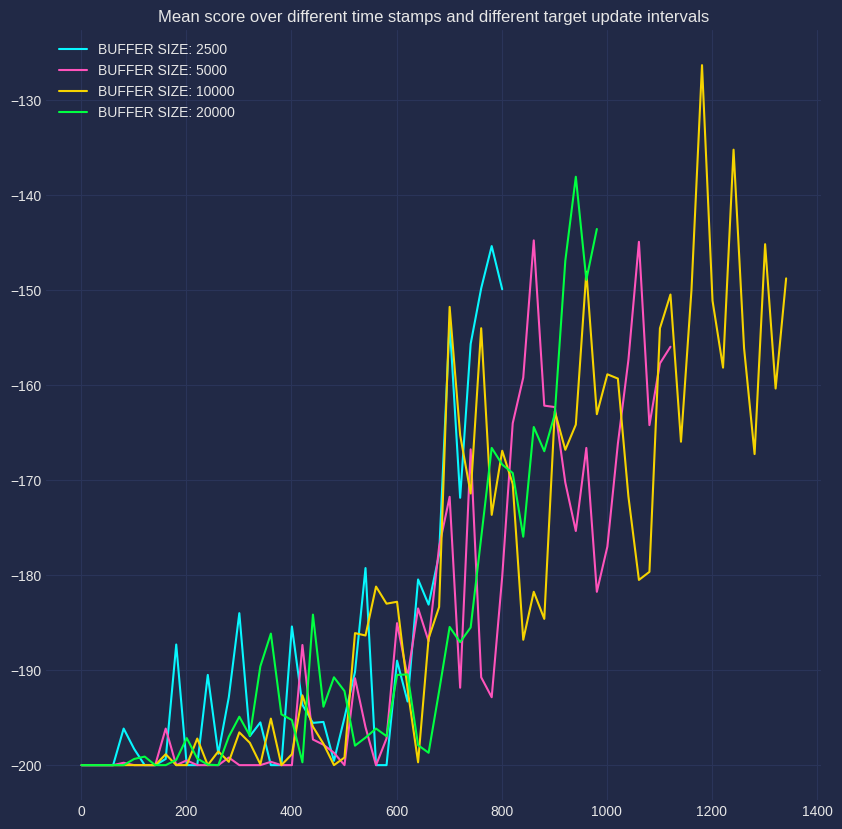

In [5]:
fig = plt.figure(figsize=(10, 10))
ax = fig.subplots()
fig.set_dpi(100)

for idx, i in enumerate(BUFFER_SIZE):
    ax.plot(range(1,NUM_EPISODES[idx]-20, 20), [sum(scores[idx][x:x+20])/20 for x, _ in enumerate(scores[idx][:-20]) if x%20==0], label=f'BUFFER SIZE: {i}')
    ax.set_title('Mean score over different time stamps and different target update intervals')
ax.legend()    
plt.show()

The plot contains mean score over 20 episodes. I've pre-prunned my models to stop the training as soon as they are good enough.

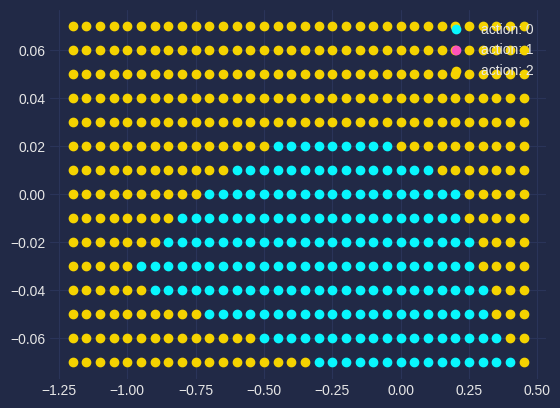

In [8]:
model = torch.load('models/mountainCar-v0-2500.h5')

fig = plt.figure()
ax = fig.subplots()


data_x = [[] for _ in range(3)]
data_y = [[] for _ in range(3)]


x = torch.arange(-1.2, 0.5, 0.05)
y = torch.arange(-0.07, 0.07, 0.01)
for i in x:
    for j in y:
        state = torch.tensor((i, j))
        action = torch.argmax(model.forward(state)).detach().__int__()
        data_x[action].append(i)
        data_y[action].append(j)
for i in range(3):
    ax.scatter(data_x[i], data_y[i], label=f'action: {i}')
ax.legend()
plt.show()

        